In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [2]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])


In [3]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,9999.998732,0.996949,0.134761,10000.001268
1,9999.996849,0.997237,0.134800,10000.003151
2,9999.994966,0.997245,0.134802,10000.005034
3,9999.993083,0.996937,0.134760,10000.006917
4,9999.991199,0.997067,0.134778,10000.008801
...,...,...,...,...
3001255,4347.829323,0.944661,0.015909,22999.982882
3001256,4347.827440,0.938258,0.015800,22999.992845
3001257,4347.825556,0.934484,0.015736,23000.002807
3001258,4347.823673,0.930303,0.015666,23000.012770


In [4]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\new_values_fe.xlsx")

raw_lambda

,Nave list
0,10035.6094
1,10067.8047
2,10084.1584
3,10087.8409
4,10092.5415
...,...
186,17688.7397
187,17775.9796
188,20722.6098
189,21254.7576


In [5]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,10035.604601,0.942222,10035.6094
1,10067.811226,0.611177,10067.8047
2,10084.158793,0.956740,10084.1584
3,10087.835211,0.968803,10087.8409
4,10092.540490,0.956926,10092.5415
...,...,...,...
186,17688.748683,0.728781,17688.7397
187,17775.974602,0.617705,17775.9796
188,20722.619681,0.760236,20722.6098
189,21254.756444,0.982279,21254.7576


### Calculate the bisector for strange lines

,Wave (cm),nFlux,rFlux,Wave A
44210,9916.739426,1.000750,0.138405,10083.959627
44211,9916.737543,1.000324,0.138346,10083.961542
44212,9916.735660,1.000161,0.138324,10083.963457
44213,9916.733776,1.000564,0.138380,10083.965372
44214,9916.731893,1.000811,0.138414,10083.967287
...,...,...,...,...
44414,9916.355239,0.993847,0.137479,10084.350307
44415,9916.353356,0.993739,0.137464,10084.352222
44416,9916.351473,0.993997,0.137500,10084.354137
44417,9916.349589,0.994628,0.137587,10084.356052


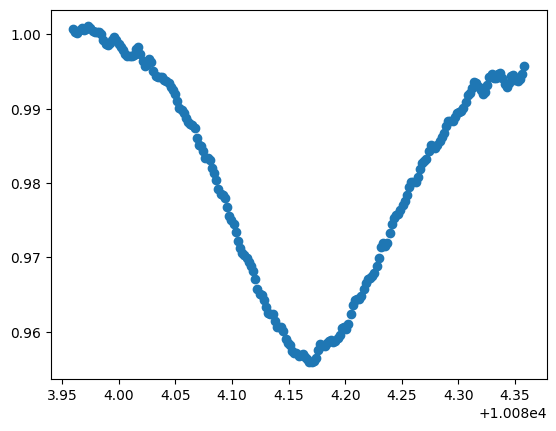

In [ ]:
# Made a great range
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points
# 
#Made a range of 0.3mA for the wavelength
local_points_bis = width_minimums(closer_lines,raw_data,0.2)

j=2
plt.scatter(local_points_bis[j]['Wave A'],local_points_bis[j]['nFlux'])

In [30]:
data_bisec = local_points_bis[j].copy()
minimum = data_bisec[data_bisec['Wave A'] == closer_lines['min_wave'].iloc[j]].index[0]
list_index = data_bisec.index.values
bisec_wave = []

left = -(min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum
right = (min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum

left_data = data_bisec.loc[left:minimum].reset_index(drop=True)
right_data = data_bisec.loc[minimum:right].sort_values('Wave A', ascending=False).reset_index(drop=True)

# bisec_flux = left_data['nFlux'].reset_index(drop=True)

bisec = pd.DataFrame()
bisec['Flux left'] = left_data['nFlux']
bisec['Flux right'] = right_data['nFlux']
bisec['Wave left'] = left_data['Wave A']
bisec['Wave right'] = right_data['Wave A']
bisec['distance'] = (bisec['Wave right'] - bisec['Wave left'])/2
bisec['c profile'] = bisec['Wave left'] + bisec['distance']

bisec

,Flux left,Flux right,Wave left,Wave right,distance,c profile
0,1.000324,0.994628,10083.961542,10084.356052,0.197255,10084.158797
1,1.000161,0.993997,10083.963457,10084.354137,0.195340,10084.158797
2,1.000564,0.993739,10083.965372,10084.352222,0.193425,10084.158797
3,1.000811,0.993847,10083.967287,10084.350307,0.191510,10084.158797
4,1.000598,0.994471,10083.969202,10084.348392,0.189595,10084.158797
...,...,...,...,...,...,...
99,0.958170,0.956285,10084.151133,10084.166454,0.007660,10084.158793
100,0.957392,0.956645,10084.153048,10084.164538,0.005745,10084.158793
101,0.957142,0.956997,10084.154963,10084.162623,0.003830,10084.158793
102,0.957088,0.956869,10084.156878,10084.160708,0.001915,10084.158793


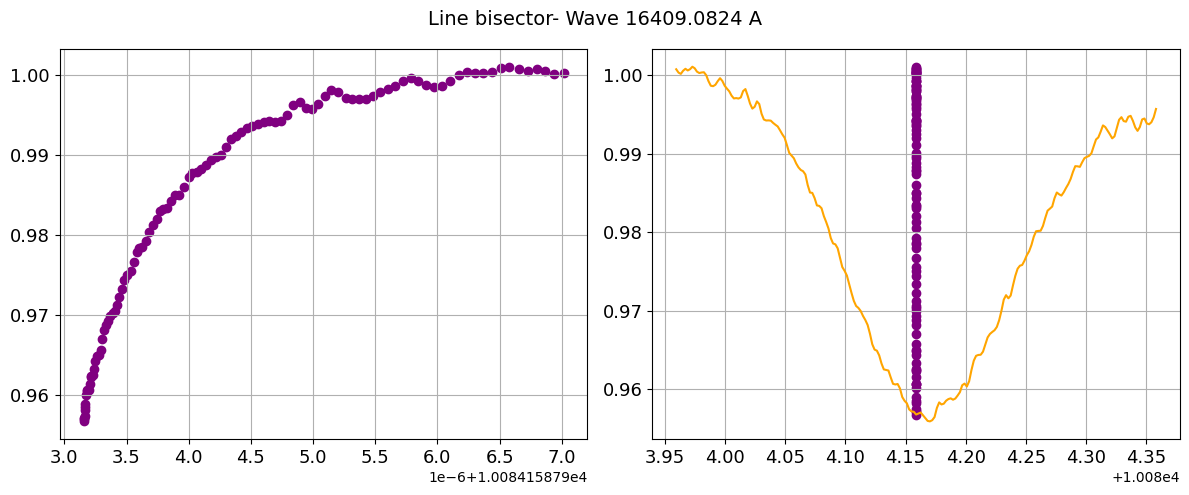

In [29]:
fig6, axis1 = plt.subplots(1,2, figsize = (12, 5))
ax1 = axis1[0]
ax2 = axis1[1]

fig6.suptitle(r'Line bisector- Wave 16409.0824 A',fontsize=14)

ax1.scatter(bisec['c profile'],bisec['Flux left'],color= 'purple')

ax2.plot(local_points_bis[j]['Wave A'],local_points_bis[j]['nFlux'],color= 'orange')
ax2.scatter(bisec['c profile'],bisec['Flux left'],color= 'purple')


ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig6.tight_layout()

# fig6.savefig('Relation_coef.pdf')